# Imporación de paquetes y montaje de Google Drive

In [ ]:
#Importación de paquetes
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as FF
import torch as tr

import torch.optim as optim

from PIL import Image

#Activación de la GPU proporcionada por Google Colab
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Utilizará GPU si está disponible

!nvidia-smi

Mon Sep  2 19:42:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
#Activación del acceso a Google Drive en la notebook
from google.colab import drive
drive.mount('/content/drive')

#Definición de un path donde se encuentran las imágenes de los frascos para el
#entrenamiento y otro para las imágenes de test
PATH = '/content/drive/MyDrive/Nube /UNL_Automatizacion y Robotica/Proyecto_final_de_la_carrera/imagenes_frascos_actualizada'
PATH_TEST = '/content/drive/MyDrive/Nube /UNL_Automatizacion y Robotica/Proyecto_final_de_la_carrera/imagenes_frascos_test_actualizada'

Mounted at /content/drive


# Funciones


In [ ]:
#Definición de una función para levantar las imagenes para entrenamiento desde una
#carpeta principal compuesta por subcarpetas divididas por las diferentes clases
def cargar_imagenes_entrenamiento(main_folder, image_size = (1080, 1920), train_test_ratio = [0.8, 0.2], image_batch_size = 16):

    #Definición de las transformaciones de aumento de datos (pueden realizarse
    #otras transformaciones activando las líneas comentadas)
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        #transforms.Resize(image_size),
        #transforms.RandomHorizontalFlip(p=0.2),
        transforms.ColorJitter(brightness=0.2, contrast=0.9, saturation=0.2, hue=0.1),  # Cambio de color
        #transforms.RandomRotation(degrees=(-5, 5)),
        transforms.RandomAffine(degrees=0.01, translate=(0.1, 0.1)),
        #transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        #transforms.RandomGrayscale(p=0.2),
        torchvision.transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    #Creación de un dataset con todas las imágenes separadas por clases y le
    #aplico las transformaciones anteriores
    dataset = ImageFolder(main_folder, transform=train_transform)

    #Partiendo del dataset general, se crean los datasets de entrenamiento y
    #validación utilizando la proporción especificada
    train_dataset_f, val_dataset_f = torch.utils.data.random_split(dataset,
                                                                train_test_ratio,
                                                                generator=torch.Generator().manual_seed(42))


    #Se devuelven los datasets creados
    return train_dataset_f, val_dataset_f

In [ ]:
#Definición de una función para levantar las imagenes de test desde una carpeta
#compuesta por subcarpetas divididas por las diferentes clases
def cargar_imagenes_test(folder, image_size = (1080, 1920), image_batch_size = 16):

    #Definición de una transformación que ajusta el tamaño de las imágenes y las
    #convierte en tensores. No se aplican técnicas de ampliación de datos
    test_transform = transforms.Compose([
        transforms.Resize(image_size),  # Ajusta el tamaño de las imágenes a 224x224 píxeles
        transforms.ToTensor()  # Convierte las imágenes en tensores de PyTorch
    ])


    #Creación de un dataset con todas las imágenes de test separadas por clases
    test_dataset_f = ImageFolder(folder, transform=test_transform)

    #Se devuelve el dataset creado
    return test_dataset_f

In [ ]:
#Función para crear un dataloader a partir de un dataset proporcionado por el usuario
def crear_dataloader(dataset_user, images_bach_size = 16, shuffle_user=True):

    #Creación de un dataloader con el dataset disponible y con el tamaño de baches deseado
    dataloader_user = DataLoader(dataset_user,
                                     batch_size=images_bach_size,
                                     shuffle=shuffle_user)

    #Se devuelve el dataset creado
    return dataloader_user

In [ ]:
#Función para mostrar imagenes
def imshow(img):
    #Se revierte la normalización colocando los valores de los pixeles en el
    #rango de [0, 1]
    img = img / 2 + 0.5

    #Se transforma el tensor de imágenes en un arreglo de numpy
    npimg = img.numpy()

    #Se reordena el arreglo anterior al formato (altura, anchura, canales)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    #Se muestran las imágenes
    plt.show()

# Visualización de datos

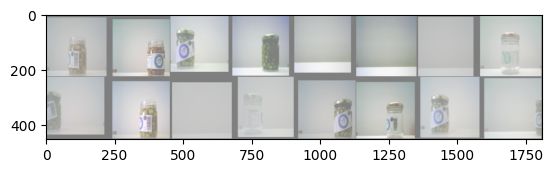

falta_tapa       falta_tapa       etiqueta_mala       falta_etiqueta       falta frasco       falta frasco       falta frasco       vacio       etiqueta_mala       falta_tapa       falta frasco       vacio       etiqueta_mala       vacio       etiqueta_mala       correcto


In [ ]:
#Denición del tamaño de lote
batch_size = 16

#Creación de los datasets para entrenamiento, validación
train_dataset, val_dataset = cargar_imagenes_entrenamiento(PATH, (224, 224))
test_dataset = cargar_imagenes_test(PATH_TEST, (224, 224))

#Creación de los dataloader para entrenamiento, validación y prueba
train_dataloader = crear_dataloader(train_dataset)
val_dataloader = crear_dataloader(val_dataset)
test_dataloader = crear_dataloader(test_dataset)


#Definición de una tupla con los nombres de las clases
classes = ('correcto', 'vacio', 'falta_etiqueta', 'etiqueta_mala', 'falta_tapa',
           'falta frasco')


#Conversión del dataloader de entrenamiento en un iterador
dataiter = iter(train_dataloader)
#Obtención de las imágenes y etiquetas por separado
images, labels = next(dataiter)

#Se muestran las imágenes en una cuadrícula
imshow(torchvision.utils.make_grid(images))
#Se imprimen las clases reales de las imágenes mostradas
print('       '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

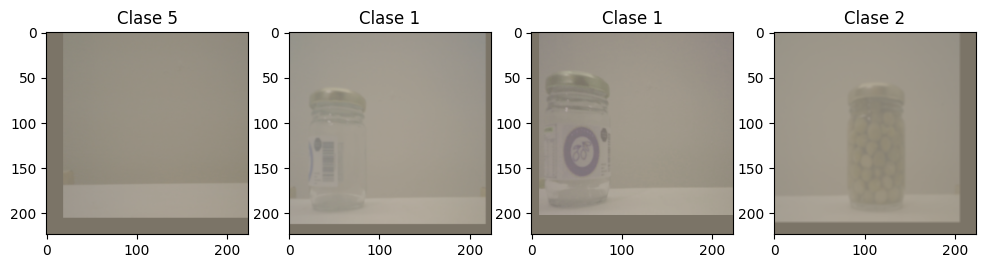

In [ ]:
#Obtención de un lote de datos aumentados
batch = next(iter(train_dataloader))
images, labels = batch

#Desnormalización las imágenes si se aplicó normalización durante la transformación
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = images * std.reshape(1, 3, 1, 1) + mean.reshape(1, 3, 1, 1)

#Conversión del tensor de PyTorch a un arreglo NumPy
images = images.numpy()

#Graficación de algunas de las imágenes obtenidas con su clase correspondiente
num_images_to_show = 4
fig, axes = plt.subplots(1, num_images_to_show, figsize=(12, 3))

for i in range(num_images_to_show):
    axes[i].imshow(np.transpose(images[i], (1, 2, 0)))
    axes[i].set_title(f"Clase {labels[i]}")

plt.show()


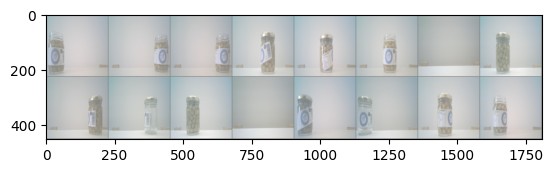

falta_tapa       falta_tapa       falta_tapa       etiqueta_mala       etiqueta_mala       falta_tapa       falta frasco       falta_etiqueta       correcto       vacio       falta_etiqueta       falta frasco       etiqueta_mala       vacio       correcto       falta_tapa


In [ ]:
#Transformación del dataloader en un iterador
dataiter = iter(test_dataloader)
#Obtención de las imágenes y etiquetas por separado
images, labels = next(dataiter)

#Se muestran las imagenes en una grilla
imshow(torchvision.utils.make_grid(images))
#Se muestran las etiquetas de las imágenes graficadas
print('       '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Modelo neuronal

In [ ]:
#Creo el modelo neuronal
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #Importación de un modelo preentrenado
        self.model = tr.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
        #Implementación de una capa de clasificación final para diferenciar las
        # clases deseadas
        self.model.classifier[1] = nn.Linear(1280, 6)

    #Definición de la pasada hacia adelante
    def forward(self, x):
        return self.model(x)


#Ruta donde se guarda el modelo preentrenado
pre_model_path = '/content/drive/MyDrive/Nube /UNL_Automatizacion y Robotica/Proyecto_final_de_la_carrera/pre_trained_model.pth'

#Guardado del modelo preentrenado en el archivo
torch.save(tr.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True), pre_model_path)

net = Net()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
#Defino un criterio de error
criterion = nn.CrossEntropyLoss()

# Entrenamiento

In [ ]:
#Función para evaluar el rendimiento de una red neuronal midiendo su accuracy y
#error medio
def calculate_accuracy(net, dataloader):
    #Inicialización en 0 de variables para contar cantidad de predicciones
    #correctas, total de predicciones y la acumulación del error
    correct = 0
    total = 0
    total_loss = 0

    #Definición de la función de pérdida utilizada
    criterion = nn.CrossEntropyLoss()

    #Desactivando el cálculo de gradientes
    with torch.no_grad():
        #Iterando a travez de los elementos del dataloader
        for data in dataloader:
            #Se obtienen las imágenes de entrada con sus etiquetas reales
            inputs, labels = data
            #Obtención de las predicciones realizadas por la red para las entradas
            outputs = net(inputs.to("cuda"))
            #Selección del valor de predicción de clase más alto para cada salida
            _, predicted = torch.max(outputs.data, 1)
            #Actualización del número total de muestras evaluadas
            total += labels.size(0)
            #Si la predicción fue correcta, aumenta en 1 un contador
            correct += (predicted == labels.to("cuda")).sum().item()
            #Cálculo de error o pérdida para el lote actual
            loss = criterion(outputs, labels.to("cuda"))
            #Se suma el error del lote actual al total de error
            total_loss += loss.item()

    #Cálculo de accuracy
    accuracy = 100 * correct / total
    #Cálculo del error medio
    error = total_loss / total

    #Se devuelven los valores de accuracy y error medio calculado
    return accuracy, error

In [ ]:
#Creación de estructura para guardar métricas
measures = {
            'trn_loss': [],
            'trn_acc': [],
            'val_loss': [],
            'val_acc': []
           }

In [ ]:
#Definición de variables
counter = 0       #Contador para chequear en validación
best_loss = 1E6   #Variable para el mejor error
best_acc = 0      #Variable para el mejor accuracy
fold = 0          #Contador de epocas de entrenamiento

#Inicialización de la red neuronal
net = Net()

#Se mueve el modelo a la GPU
net = net.to("cuda")

#Definición del optimizador
optimizer = optim.Adam(net.parameters(), lr=1e-3)


#El entrenamiento durará 1o epocas o hasta que se alcanse el límite del
#contador, indicando que el modelo está memorizando los datos
while (fold < 10) and (counter < 20):
    #Reinicio de los valores de error actual, contador y mejor epoca para este fold
    running_loss = 0.0
    counter = 0
    best_epoch = 0

    #Se itera sobre el dataloader de entrenamiento
    for i, data in enumerate(train_dataloader, 0):

        #Obtención de las entradas y las etiquetas por separado
        inputs, labels = data

        #Se ponen en cero o reinicial los gradientes de los parámetros
        optimizer.zero_grad()

        #Paso hacia adelante calculando las salidas de la red
        outputs = net(inputs.to("cuda"))
        #Cálculo entre las salidas de la red y las etiquetas verdaderas
        loss = criterion(outputs, labels.to("cuda"))
        #Paso hacia atrás calculando el gradiente de la pérdida respecto a los parámetros
        loss.backward()
        #Actualización de los parámetros de la red con el optimizador
        optimizer.step()

        #Se acumula el error actual a una suma de error total
        running_loss += loss.item()

        #Se calcula el accuracy y el error medio para el dataloader de
        #entrenamiento y validación
        train_accuracy, train_loss = calculate_accuracy(net, train_dataloader)
        val_accuracy, val_loss = calculate_accuracy(net, val_dataloader)

        #Guardado de las métricas obtenidas en un diccionario
        measures['trn_loss'].append(train_loss)
        measures['trn_acc'].append(train_accuracy)
        measures['val_loss'].append(val_loss)
        measures['val_acc'].append(val_accuracy)

        #Impresión de las métricas por cada época de entrenamiento
        if (i%1) == 0:
            print(f'Epoch {i}: trn_loss: {train_loss:.5}\t val_loss: {val_loss:.5}\t trn_acc: {train_accuracy}\t val_acc: {val_accuracy}\t counter: {counter}')


        #=================================
        #Si el error actual es menor al mejor error registrado
        if (val_loss < best_loss):

            #Actualización del mejor error al error actual
            best_loss = val_loss
            #Guardado de la mejor época
            best_epoch = i
            #Actualización del mejor valor de accuracy
            best_acc = val_accuracy

            #Guardado del modelo actual como un diccionario
            best_model = net.state_dict()
            counter = 0  #Reinicio del contador

        #Si esta época no fue mejor que la anterior
        else:
            counter += 1 #Aumenta el contador en 1

    #=================================
    #Al finalizar una etapa de entranamiento, se muestan los mejores resultados
    print('-' * 30)
    print(f'Fold {fold + 1}:')
    print(f'Best Epoch: {best_epoch:}')
    print(f'Best Loss: {best_loss:.2f}')
    print(f'Best Accuracy: {best_acc:.2f}')
    print(f'Counter: {counter:}')
    print('=' * 30)

    #Se aumenta el contador de etapas
    fold += 1


#Al finalizar el entrenamiento se muestra un mensaje
print('Finished Training')

#Definición de la ruta donde se guarda el modelo entrenado
model_path = '/content/drive/MyDrive/Nube /UNL_Automatizacion y Robotica/Proyecto_final_de_la_carrera/best_model.pth'

#Guardado del modelo entrenado en el archivo
torch.save(best_model, model_path)

#Se imprime un mensaje anunciando que se guardo el modelo
print('=' * 30)
print("Modelo guardado")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0: trn_loss: 0.087022	 val_loss: 0.084701	 trn_acc: 51.041666666666664	 val_acc: 52.083333333333336	 counter: 0
Epoch 1: trn_loss: 0.079618	 val_loss: 0.082808	 trn_acc: 53.125	 val_acc: 47.916666666666664	 counter: 0
Epoch 2: trn_loss: 0.063129	 val_loss: 0.067709	 trn_acc: 59.895833333333336	 val_acc: 58.333333333333336	 counter: 0
Epoch 3: trn_loss: 0.04282	 val_loss: 0.05427	 trn_acc: 78.125	 val_acc: 64.58333333333333	 counter: 0
Epoch 4: trn_loss: 0.030969	 val_loss: 0.048629	 trn_acc: 83.33333333333333	 val_acc: 70.83333333333333	 counter: 0
Epoch 5: trn_loss: 0.026806	 val_loss: 0.04058	 trn_acc: 84.375	 val_acc: 75.0	 counter: 0
Epoch 6: trn_loss: 0.024746	 val_loss: 0.042572	 trn_acc: 88.02083333333333	 val_acc: 83.33333333333333	 counter: 0
Epoch 7: trn_loss: 0.019029	 val_loss: 0.04505	 trn_acc: 89.0625	 val_acc: 75.0	 counter: 1
Epoch 8: trn_loss: 0.011176	 val_loss: 0.035158	 trn_acc: 95.3125	 val_acc: 83.33333333333333	 counter: 2
Epoch 9: trn_loss: 0.016311	 val_l

# Visualización de métricas:

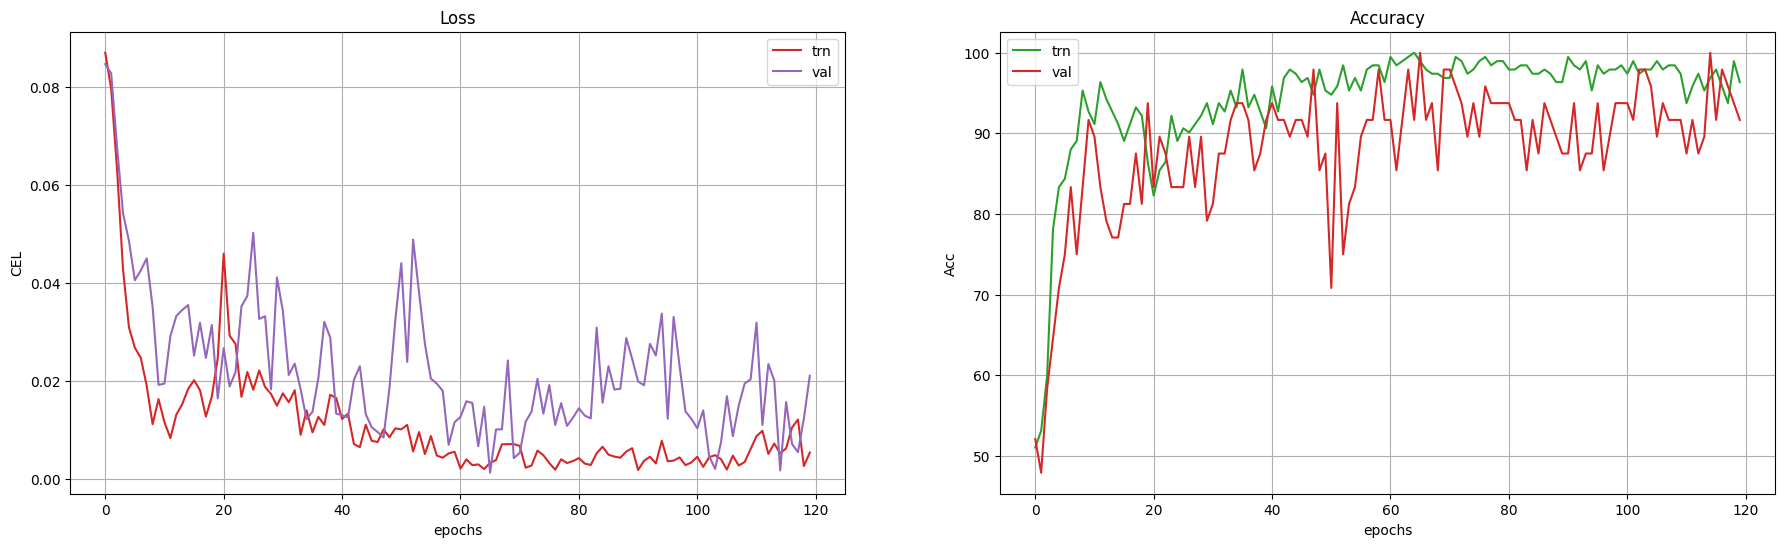

In [ ]:
#Creación de un gráfico doble
fig, ax = plt.subplots(1,2,figsize=(22,6))

#En el primer gráfico se muestran los valores de error para los dataloader de
#entrenamiento y validación
ax[0].plot(measures['trn_loss'], 'C3', label='trn')
ax[0].plot(measures['val_loss'], 'C4', label='val')
ax[0].set_title('Loss')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('CEL')
ax[0].grid(True)
ax[0].legend()

#En el segundo gráfico se muestran los valores de accuracy para los dataloader
#de entrenamiento y validación
ax[1].plot(measures['trn_acc'], 'C2', label='trn')
ax[1].plot(measures['val_acc'], 'C3', label='val')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Acc')
ax[1].grid(True)
ax[1].legend();

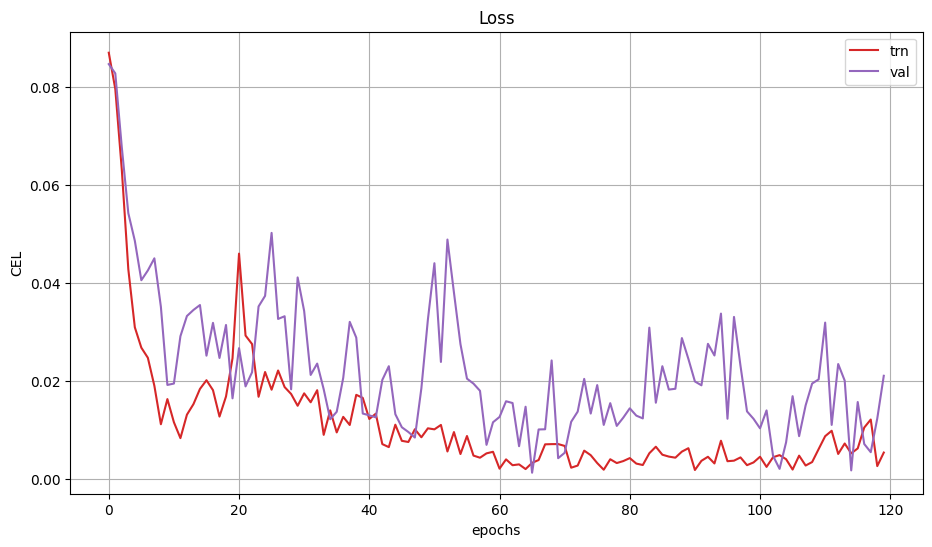

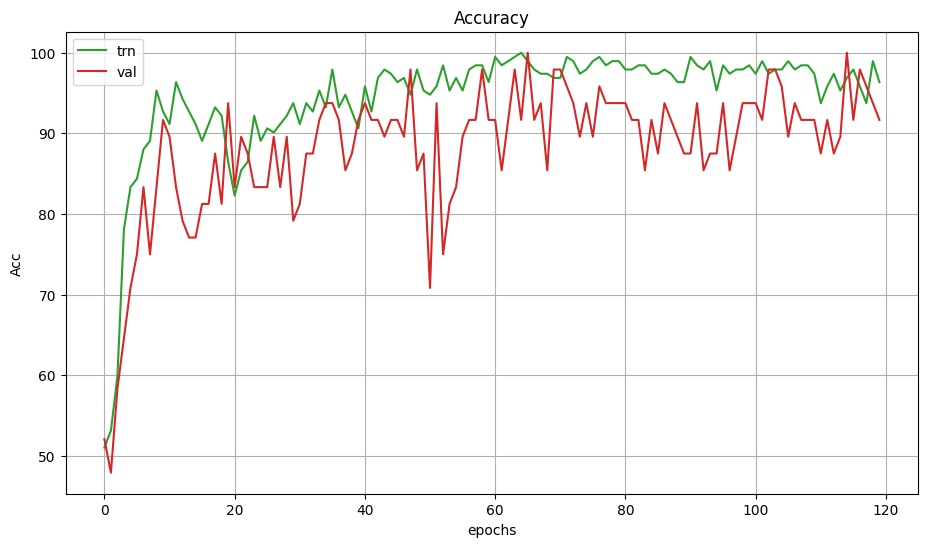

In [ ]:
#Creación de un gráfico doble
fig, ax = plt.subplots(1,1,figsize=(11,6))

#En el primer gráfico se muestran los valores de error para los dataloader de
#entrenamiento y validación
ax.plot(measures['trn_loss'], 'C3', label='trn')
ax.plot(measures['val_loss'], 'C4', label='val')
ax.set_title('Loss')
ax.set_xlabel('epochs')
ax.set_ylabel('CEL')
ax.grid(True)
ax.legend()

plt.show()

fig, ax = plt.subplots(1,1,figsize=(11,6))
#En el segundo gráfico se muestran los valores de accuracy para los dataloader
#de entrenamiento y validación
ax.plot(measures['trn_acc'], 'C2', label='trn')
ax.plot(measures['val_acc'], 'C3', label='val')
ax.set_title('Accuracy')
ax.set_xlabel('epochs')
ax.set_ylabel('Acc')
ax.grid(True)
ax.legend();

plt.show()

# Prueba:

In [ ]:
#Inicialización de la red
net = Net()
#Se carga en la red el mejor modelo obtenido en el entrenamiento
net.load_state_dict(best_model)
#Se mueve la red a la GPU
net = net.to("cuda")

#Cálculo del error y accuracy en test
test_accuracy, test_loss = calculate_accuracy(net, test_dataloader)

#Se imprimen los resultados obtenidos sobre el error y el accuracy en test
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Test Loss: 0.0018
Test Accuracy: 100.0000
